In [190]:
import numpy as np
import pandas as pd
import scipy.stats as stats

#Packages for plotting
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

Goal is to explore and model grid cells as per Ocko et al. 2018. Equations and all information can be found in that paper. 

Let's work through the paper. We'll start with the 1 Dimensional implementation using ring attractor networks.

In [191]:
#Number of neurons
N = 20
#Neuron coords
U = np.linspace(0, 2*np.pi, N+1)[:-1]
#Activity matrix
A = np.zeros(20)

In [192]:
#Helper function to visualize networks
def plot_ring(u, A):
    x = np.cos(u)
    y = np.sin(u)
    fig, ax = plt.subplots()
    fig.set_size_inches((4.5,4.5))
    ax.scatter(x,y, c=A, marker='o', s=500)
    ax.set_xbound(-1.5,1.5)
    ax.set_ybound(-1.5,1.5)
    #ax.set_title('Ring Attractor Network Activity')

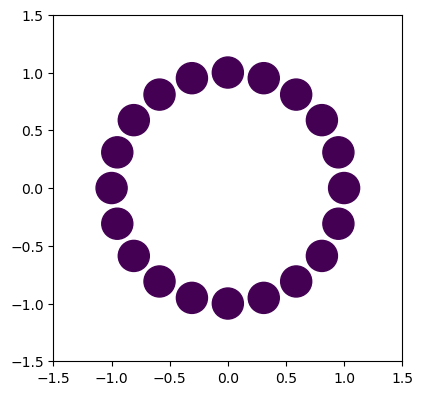

In [193]:
plot_ring(U,A)

In this case, we are plotting the activity for each neuron. As we have set the activity of the network to 0, they're all the same.

Next, let's calculate the non-conjunctive attractor cell weights.

In [194]:
#Calculates Distance matrix D of all neuron coords
def calc_D(u):
    D = u.reshape((-1,1))
    D = (D@np.ones_like(D.T)).T
    D = D - D.T
    return D

#Weight matrix with J function applied, in this case cosine
Wj = np.cos(calc_D(U))

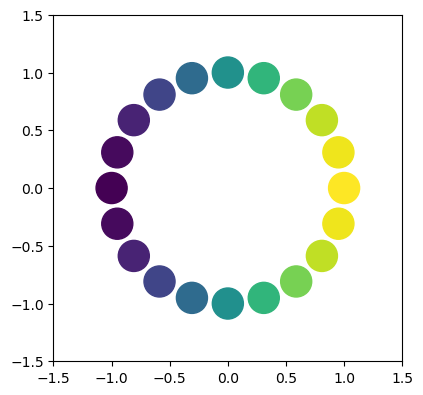

In [195]:
#plotting weights of cell at position 0
plot_ring(U,Wj[0])

Above we've plotted the weights of cell 0, using cosine as our J function. We can see that it excites cells close by, decreasing with distance until it eventually inhibits. Now, let's plot the entire weight matrix

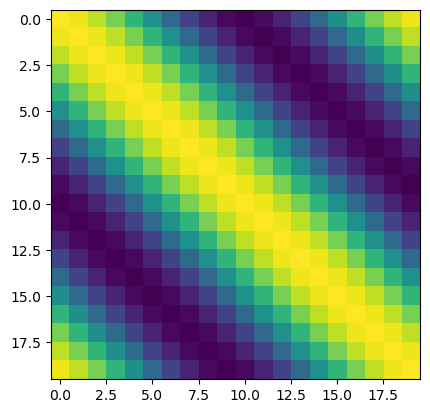

In [196]:
plt.imshow(Wj)

Crazy. Ok, now we'll add the East and West attractor networks and calculate the activity

In [197]:
def east(v, vc, u):
    if v > 0:
        return (v/vc)*u
    else:
        return 0

def west(v, vc, u):
    if v < 0:
        return (-v/vc)*u
    else:
        return 0

#non-linearity function
def G(h):
    h[h<=-1] = -1
    h[h>=1] = 1
    return h

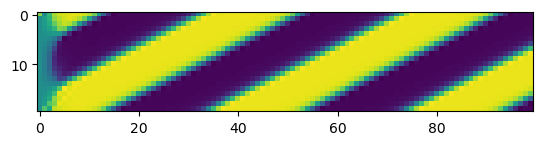

In [198]:
#Number of neurons
N = 20
#Neuron coords
U = np.linspace(0, 2*np.pi, 21)[:-1]
#Distance Matrix
D = calc_D(U)
#Total time
T = 100
#Stores activity at each timestep
At = np.zeros((T,N))
#leak constant 
Tau_m = 5
#controls weight distribution
j0 = 0.2
#Path integration strength
e_pi = 1
#Velocity adjustment
vc = 1
#bias of east/west networks
bias = 1
#velocity
v = 0.5

#Recurrent network, needs some initial or external activity to work. In this case no landmark, so initializing first neuron
At[0][0] = 1
for t in range(T-1):
    At[t+1] = -(At[t]/Tau_m) + G(j0*np.cos(D)@At[t]) + e_pi*(east(v, vc, np.roll(At[t],-bias))) + e_pi*(west(v, vc, np.roll(At[t],bias))) 

plt.imshow(At.T)

In [199]:
@widgets.interact
def f(x=(0,80)):
    plot_ring(U, At[x])

interactive(children=(IntSlider(value=40, description='x', max=80), Output()), _dom_classes=('widget-interact'…

Findings: \
e_pi and vc both modulate the velocity, just in opposite ways. So not much point in having both, unless the move to higher dimensions make both useful?
\
j0 controls strength of non-conjunctive network. Too high and the velocity won't have an effect, too low and the network won't have any activity

OK, let's try and add the landmark cells to replicate the figure in the paper (ie. two border cells). This means we'll also need to simulate the velocity of an agent travelling repeatedly between two walls.

In [228]:
#Number of neurons
N = 20
#Number of landmark neurons
N_l = 2
#Neuron coords
U = np.linspace(0, 2*np.pi, 21)[:-1]
#Distance Matrix
D = calc_D(U)
#Weight matrix
Wt = np.zeros((T,N,N))
#Total time
T = 100
#Session time, used for hebbian learning of landmark cell weights
Ts = 300
#Stores activity at each timestep
At = np.zeros((T,N))
#Stores session activity at each timestep
Ats = np.zeros((Ts,N))
#Stores activity of landmark cells at each timestep
At_l = np.zeros((T,N_l))
#Stores session activity of landmark cells at each timestep
Ats_l = np.zeros((Ts,N_l))
#leak constant 
Tau_m = 5
#controls weight distribution
j0 = 0.1
#Path integration strength
e_pi = 1
#Velocity adjustment
vc = 2
#bias of east/west networks
bias = 1
#time to traverse room
tau = 25
#length of room
L = 25
#velocity magnitude
v0 = L/tau
#initialize velocity
v = -v0
#Weights of landmark cells
Wt_l = np.zeros((T,N_l,N))

At[0][0] = 1
Wt[0] = np.cos(D)
Wt_l[0][0][np.random.randint(N)] = 1
Wt_l[0][1][np.random.randint(N)] = 1

ts = 0
dW = 0

for t in range(T-1):
    #Training session ended
    if ts == Ts:

        dw = (np.mean(Ats*Ats_l))/(np.mean(Ats_l))

        Ats = np.zeros((Ts,N))
        Ats_l = np.zeros((Ts,N_l))
        ts = 0

    #If at edge of room, east or west, turn around, activate landmark cell
    if t%(2*tau) == 0:
        v = -v
        At_l[t][1] = 1
        Ats_l[ts][1] = 1
    elif t%tau == 0:
        v = -v
        At_l[t][0] = 1
        Ats_l[ts][0] = 1
    else:
        At_l[t] = 0
        Ats_l[ts] = 0

    Wt[t+1] = Wt[t]

    Wt_l[t+1] = Wt_l[t] + dW

    At[t+1] = -(At[t]/Tau_m) + G(j0*Wt[t]@At[t]) + e_pi*(east(v, vc, np.roll(At[t],-bias))) + e_pi*(west(v, vc, np.roll(At[t],bias)))
    At[t+1] = At[t+1] #+ Wt_l[t]@At_l[t]

    Ats[t+1] = At[t+1]

    ts +=1

In [245]:
Wt_lTEST = np.zeros((T,N_l,N))
Wt_lTEST[0][0] = Ats_l[25][0] * Ats[25]
Wt_lTEST[0][1] = Ats_l[25][1] * Ats[25]

In [243]:
Ats[25]

array([-1.41981927, -1.38713123, -1.23386755, -0.64662612,  0.0766956 ,
        0.77786872,  1.32313105,  1.42498194,  1.4281371 ,  1.42660731,
        1.41980296,  1.38715288,  1.23384408,  0.64664725, -0.07671156,
       -0.77785847, -1.32313692, -1.42497791, -1.42814253, -1.4265973 ])

In [229]:
@widgets.interact
def f(x=(0,T-51)):
    plt.imshow(At.T[:,x:x+50])

interactive(children=(IntSlider(value=24, description='x', max=49), Output()), _dom_classes=('widget-interact'…

In [38]:
@widgets.interact
def f(x=(0,T-1)):
    plot_ring(U, At[x])

interactive(children=(IntSlider(value=499, description='x', max=999), Output()), _dom_classes=('widget-interac…